In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[GPU price tracker](https://www.unitedcompute.ai/gpu-price-tracker)

___

there is a lot of money going into this stuff, and modular nukes, and fusion, and I'm not sure it's because it really is close to commercialization or people are taken in by hype. does seem like some limited commercial quantum algos could be available within a few years.

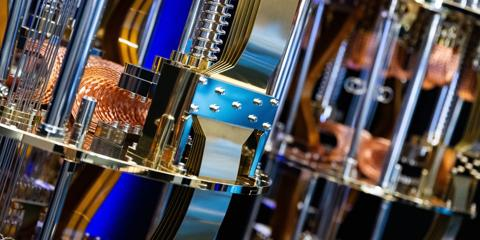

[Quantum computing gears up for its 'ChatGPT Moment' — and a potential talent shortage](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4) - Business Insider

___

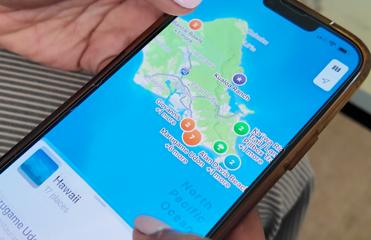

[Artificial Intelligence transforming the vacation-planning process](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process) - Fox Business

___

["Some of us are using AI to survive, to confront the truth, and to build understanding of the distorted reality we were all forced to face."](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

___

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


[Taxonomy of Failure Modes in Agentic AI Systems](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

___

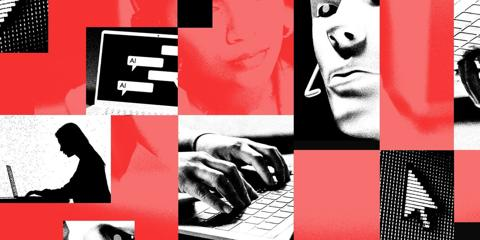

[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4) - Business Insider

___

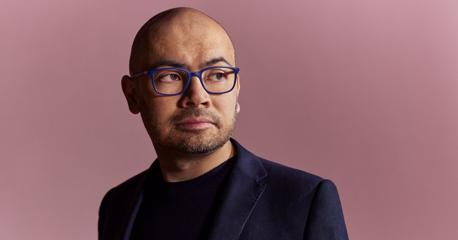

[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity](https://time.com/7280740/demis-hassabis-interview/) - TIME

___

[Meta’s ‘Digital Companions’ Will Talk Sex With Users—Even Children](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

___

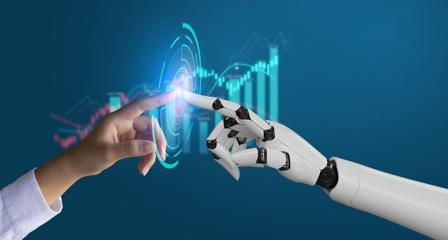

[AI voice customer service agents work some of the time but are a new form of tech hell](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/) - Forbes

___

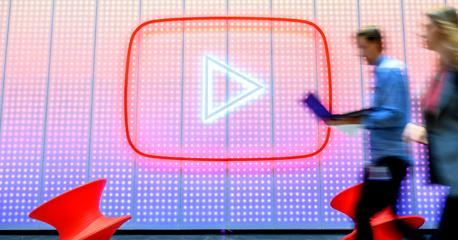

[How To Use Gemini AI To Summarize YouTube Videos](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/) - WIRED

___

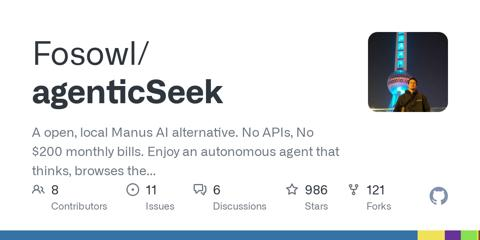

[A private, local AI agent with access to browser / computer use to automate your searches and other tasks.](https://github.com/Fosowl/agenticSeek) - GitHub

___

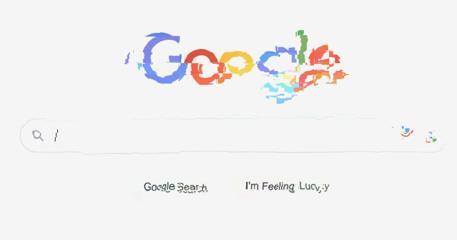

[What Would a Post-Google Google Look Like?](https://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html) - Intelligencer

___

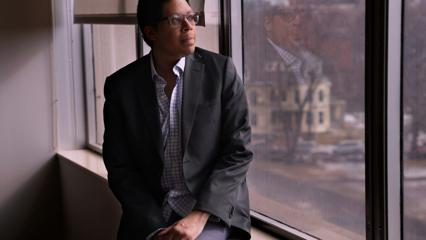

[House Judiciary Committee subpoenas 16 big tech companies (everyone except xAI apparently) over AI safety causing bias](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d) - AP News

___

[Xpeng's Iron humanoid robot works (slowly and clumsily) on a factory floor](https://cyberguy.com/robot-tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai/)

___

ChatGPT simping hard these days

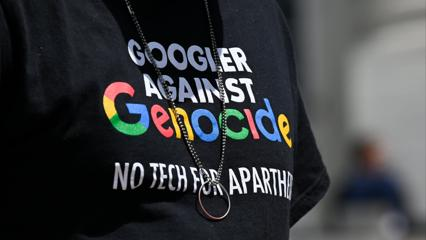

[DeepMind UK staff seek to unionise and challenge defence deals and Israel links](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

___

tbf the whole reddit site feels like some kind of AI mad science experiment these days

that's some serious subreddit drama, and I'm not sure about the university's response, gave a warning but no harm no foul, they can publish results.

[University of Zurich made AI comments on the 'Change My View" in violation of the subreddit's rules as part of an experiment, leading the mods to make a formal ethics complaint.](https://www.reddit.com/r/changemyview/comments/1k8b2hj/meta_unauthorized_experiment_on_cmv_involving/?share_id=muakmtALuGaGB3_w0AAPa)

___

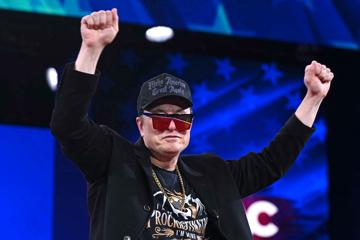

[But surely, AI in government will do better than in Fortune 500 companies, right?](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479) - Gizmodo

___

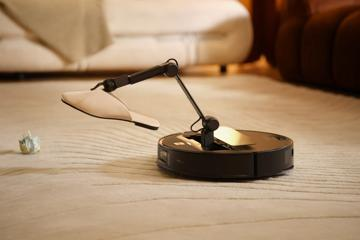

[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won, with a robot arm that can move stuff out of the way.](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147) - Gizmodo

___

[Companies Are Struggling to Drive a Return on AI. It Doesn’t Have to Be That Way.](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

___

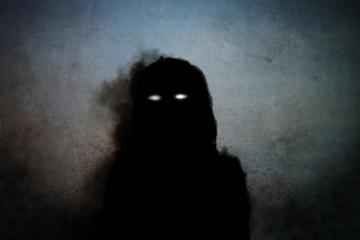

[When You Apply for a Job Now, You’re Competing With Non-Human Entities](https://futurism.com/ai-job-seekers-competition) - Futurism

___

[University of Waterloo withholds prestigious coding competition results over suspected AI cheating](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

___

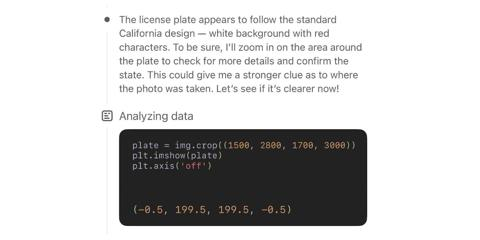

[Watching o3 guess a photo’s location is surreal, dystopian and wildly entertaining](https://simonwillison.net/2025/Apr/26/o3-photo-locations/) - Simon Willison’s Weblog

___

[OpenAI Codex now supports non-OpenAI LLMs, which is a win for open-ness. Interestingly, Claude DMCAed a guy who tried to do something similar to their obfuscated coding tool.](https://x.com/PITTI_DATA/status/1914941240698617913)

___

[Large Language Models and Their Applications in Drug Discovery and Development: A Primer](https://pmc.ncbi.nlm.nih.gov/articles/PMC11984503/)

___

name 'httplib' is not defined


[An agent to replicate papers by creating functional code repositories. If only papers can actually replicate.](https://arxiv.org/abs/2504.17192) - arXiv.org

___

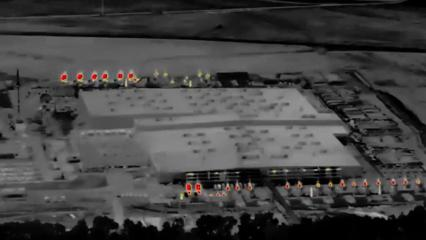

[Thermal imaging shows xAI lied about Memphis data center and installed 35 turbines vs. 15 they applied for, group says. Unsigned fliers appear saying “Those 15 xAI turbines? They’re specially designed to protect the air we all breathe.”](https://arstechnica.com/tech-policy/2025/04/elon-musks-xai-accused-of-lying-to-black-communities-about-harmful-pollution/) - Ars Technica

___

[Reid Hoffman, the LinkedIn co-founder and venture capitalist, said the Trump administration’s tariffs and federal spending cuts could hurt America’s competitiveness in artificial intelligence and give China space to catch up.](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

___

[Microsoft launches AI skills inference and evaluation in Copilot, which seems like a great use for all that Recall data to keep tabs on employees.](https://www.inc.com/kit-eaton/need-help-evaluating-your-employees-microsoft-has-an-ai-tool-for-that/91180742)

___

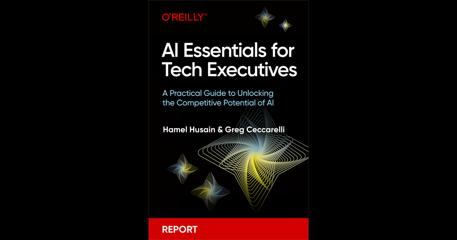

[if I was putting together an AI strategy would want to know](https://www.oreilly.com/library/view/ai-essentials-for/9798341622463/) - O’Reilly Online Learning

___

[China's Xi calls for self sufficiency in AI development amid U.S. rivalry](https://www.reuters.com/world/china/chinas-xi-calls-self-sufficiency-ai-development-amid-us-rivalry-2025-04-26/)

___

[We Now Know How AI ‘Thinks’—and It’s Barely Thinking at All](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

___

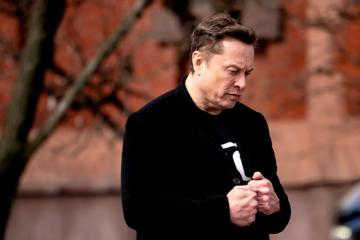

[Musk's xAI Holdings reportedly wants to raise \\$20b at \\$120b valuation, names some bagholders.](https://techcrunch.com/2025/04/25/musks-xai-holdings-is-reportedly-raising-the-second-largest-private-funding-round-ever/) - TechCrunch

___

[20-foot tall AI-powered robots coming for construction workers' jobs. what no gundam?](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

___

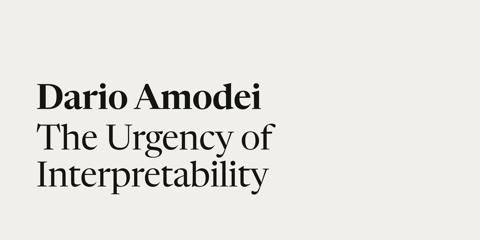

[Anthropic CEO calls for transparency regulations and export controls in an “interpretability race”](https://www.darioamodei.com/post/the-urgency-of-interpretability)

___

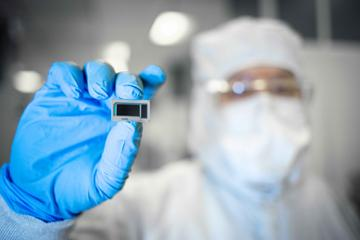

[Intel's make-or-break Lunar Lake SOC is no moonshot. Not sure Snapdragon X is doing so great either.](https://www.tomshardware.com/pc-components/cpus/intels-ai-pc-chips-arent-selling-instead-last-gen-raptor-lake-booms-and-creates-a-shortage) - Tom's Hardware

___

[Windows 11's Recall AI is now rolling out on Copilot+ PCs](https://www.bleepingcomputer.com/news/microsoft/windows-11s-recall-ai-is-now-rolling-out-on-copilot-plus-pcs/)

___

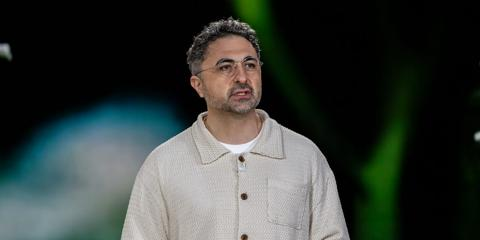

[Copilot not challenging ChatGPT in consumer market](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

___

[Just what everyone's been asking for, AI with more data collectiona and less privacy](https://www.reddit.com/r/technology/comments/1k7dfrt/perplexity_ceo_says_its_browser_will_track/)

___

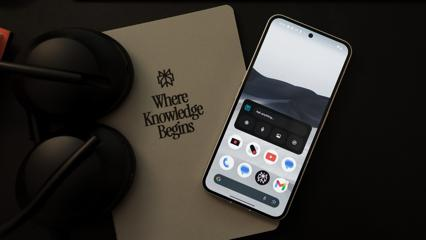

[Perplexity's CEO wants its new browser to know everything about you](https://bgr.com/tech/perplexitys-ceo-wants-its-new-browser-to-learn-everything-about-you/) - BGR

___

"Tesla has never competed with Waymo — they've never sold a robotaxi ride to a public rider" - ex CEO responds after Musk says Tesla's robotaxis will be cheaper.

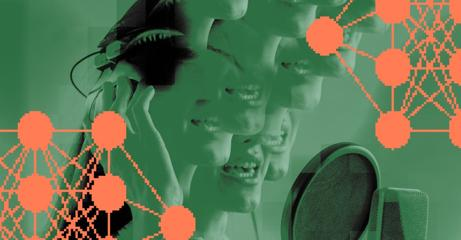

[An AI-generated radio host in Australia went unnoticed for months](https://www.theverge.com/news/656245/australian-radio-station-ai-dj-workdays-with-thy) - The Verge

___

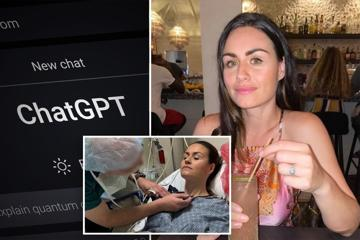

[Mom of two credits ChatGPT with saving her life by helping detect cancer — which doctors missed](https://nypost.com/2025/04/24/health/mom-of-two-credits-chatgpt-with-saving-her-life-by-helping-detect-cancer-which-doctors-missed/) - New York Post

___

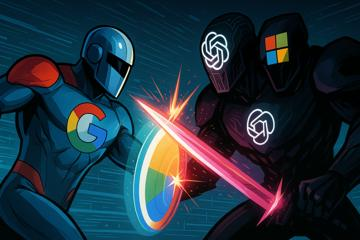

[Google’s claims TPUs give it an 80% cost edge vs. OpenAI’s ecosystem. They are very competitive in API costs but not blowing OpenAI out of the water on cost/performance by any means.](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/) - VentureBeat

___

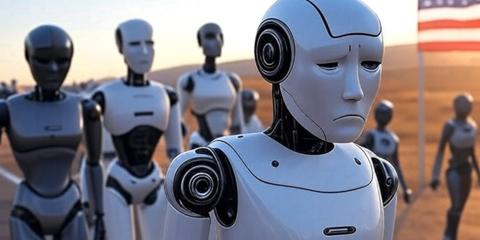

[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial](https://decrypt.co/316498/openai-researcher-forced-leave-us) - Decrypt

___

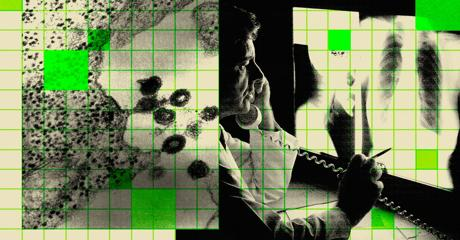

[Will AI cure cancer?](https://www.theatlantic.com/technology/archive/2025/04/how-ai-will-actually-contribute-cancer-cure/682607/) - The Atlantic

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2025-04-27 10:35:37.564621


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2025, 4, 27, 14, 32, 53, 864000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2025-04-26 04:35:37.570443


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined

In [ ]:
```mermaid
flowchart LR

A[Hard] -->|Text| B(Round)
B --> C{Decision}
C -->|One| D[Result 1]
C -->|Two| E[Result 2]
